In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *


In [2]:
from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
# import train_test_split
from sklearn.model_selection import train_test_split

In [3]:
import pickle

In [4]:
np.isnan(torch.tensor(2).item())


False

In [4]:
#os.environ["CUDA_VISIBLE_DEVICES"]='2'


CUDA = True
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}


In [5]:
cd ..

/home/rd804/m-anode


In [7]:
# define nan


In [6]:
with open('data/data.pkl', 'rb') as f:
    data = pickle.load(f)

back_mean = 0
sig_mean = 3
sig_simga = 0.5
back_sigma = 3

with open('data/true_w.pkl', 'rb') as f:
    true_w = pickle.load(f)

with open('data/background.pkl', 'rb') as f:
    background = pickle.load(f)


# fit train data
best_parameters = {}
run = 0

sig_train = 1

best_parameters[str(sig_train)] = {}

# Load train data
x_train = data[str(sig_train)]['train']['data']

_X_train = np.concatenate((x_train, background), axis=0)
_y_train = np.concatenate((np.ones(len(x_train)), np.zeros(len(background))), axis=0)






_X_train, _y_train  = shuffle(_X_train, _y_train, random_state=10)


X_train , X_val = train_test_split(_X_train, test_size=0.5, random_state=22)
y_train , y_val = train_test_split(_y_train, test_size=0.5, random_state=22)


In [28]:
len(y_train[y_train==0])

49863

In [7]:
x_test = data['10']['val']['data']
label_test = data['10']['val']['label']

testtensor = torch.from_numpy(x_test.reshape(-1,1)).float()


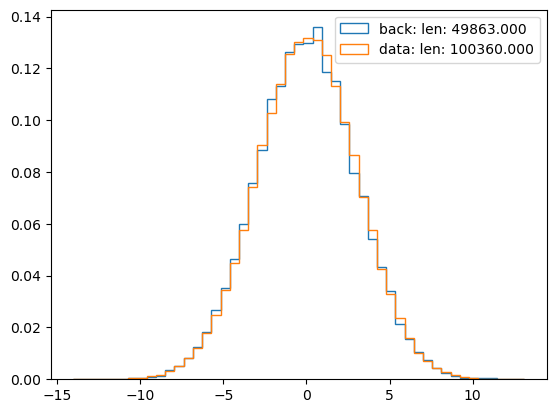

In [8]:
bins = np.linspace(min(X_train), max(X_train), 50)

plt.hist(X_train[y_train==0], bins=bins, label='back: len: %.3f' % len(X_train[y_train==0]) , density=True, histtype='step')
plt.hist(X_train[y_train==1], bins=bins, label='data: len: %.3f' % len(X_train[y_train==1]), density=True, histtype='step')
plt.legend()
#plt.hist(, bins=100, alpha=0.5, label='val', density=True, histtype='step')
plt.show()

In [9]:
# define X_train y_train to be used for loading to dataloader

batch_size = 128

X_train = torch.from_numpy(X_train.reshape(-1,1)).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()

X_val = torch.from_numpy(X_val.reshape(-1,1)).float()
y_val = torch.from_numpy(y_val.reshape(-1,1)).float()

traindataset = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)

valdataset = torch.utils.data.TensorDataset(X_val, y_val)
valloader = torch.utils.data.DataLoader(valdataset, batch_size=batch_size*5, shuffle=False)



In [60]:
device

device(type='cuda', index=0)

In [10]:
model_S=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0, device=device)
model_B=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0, device=device)

#w = torch.tensor(0.0, requires_grad=True, device=device)

#optimizer = torch.optim.Adam(list(model_S.parameters()) + list(model_B.parameters()) + [w], lr=1e-3)

In [11]:
def inverse_sigmoid(x):
    x = torch.tensor([x])
    return torch.log(x/(1-x))

In [12]:
valloss = np.load('results/nflows_gaussian_mixture_1/CR/try_0/valloss_list_background.npy')

index = np.argmin(valloss).flatten()[0]

model_B.load_state_dict(torch.load(f'results/nflows_gaussian_mixture_1/CR/try_0/model_CR_{index}.pt'))

w_ = 0.01
w_ = inverse_sigmoid(w_)

print(w_)

w = torch.tensor(w_, requires_grad=True, device=device)

optimizer = torch.optim.Adam(list(model_S.parameters()), lr=1e-3)

tensor([-4.5951])


/tmp/ipykernel_850242/3184660403.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(w_, requires_grad=True, device=device)


In [64]:
w

tensor([-2.9444], device='cuda:0', requires_grad=True)

In [78]:
torch.sigmoid(torch.tensor(-2.9))

tensor(0.0522)

In [53]:
w_ = true_w['1'][0]
print(w_)


0.002230015914431246


tensor([-4.5951], device='cuda:0', requires_grad=True)
epoch: 0, train_loss: 386066.528, val_loss: 386023.852
w: -4.595


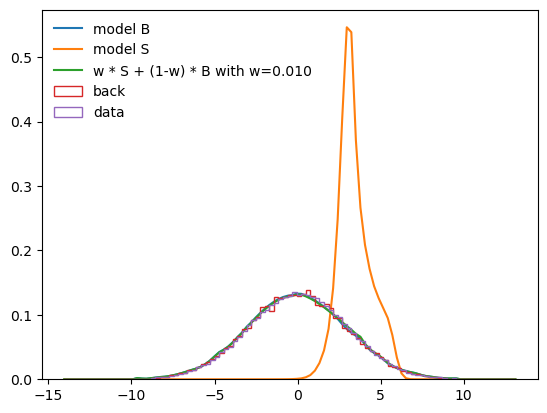

epoch: 1, train_loss: 386061.870, val_loss: 386020.574
w: -4.595


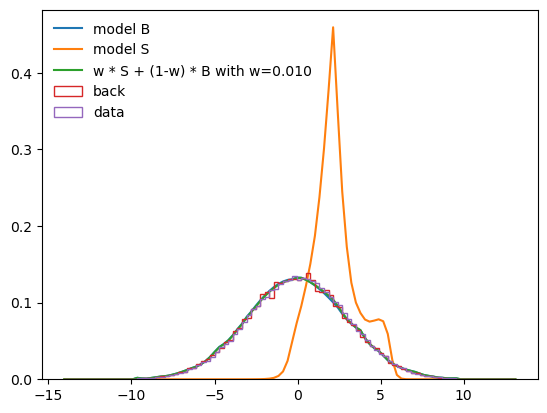

epoch: 2, train_loss: 386057.670, val_loss: 386021.815
w: -4.595


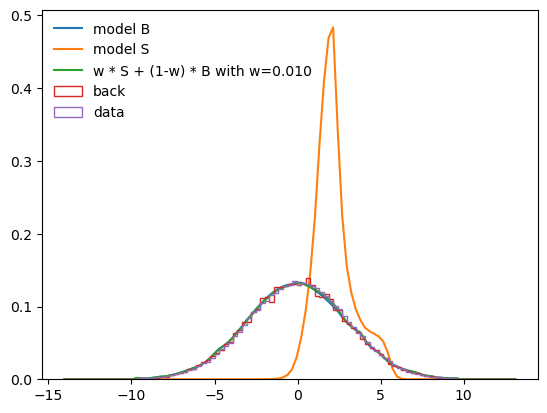

epoch: 3, train_loss: 386055.107, val_loss: 386032.436
w: -4.595


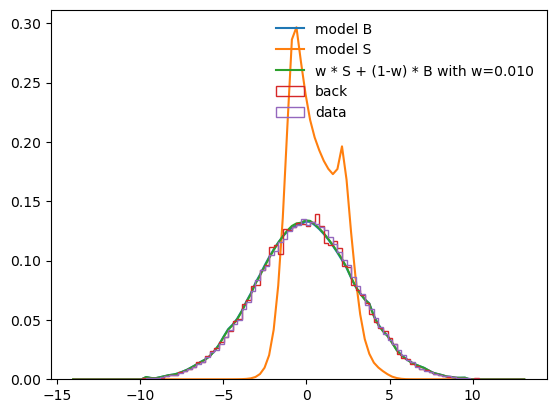

epoch: 4, train_loss: 386056.226, val_loss: 386034.562
w: -4.595


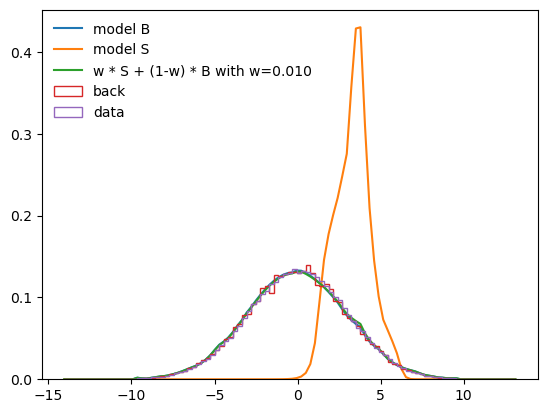

epoch: 5, train_loss: 386054.413, val_loss: 386020.695
w: -4.595


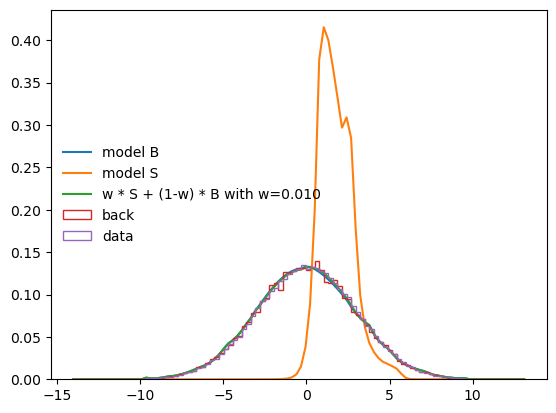

epoch: 6, train_loss: 386054.462, val_loss: 386020.403
w: -4.595


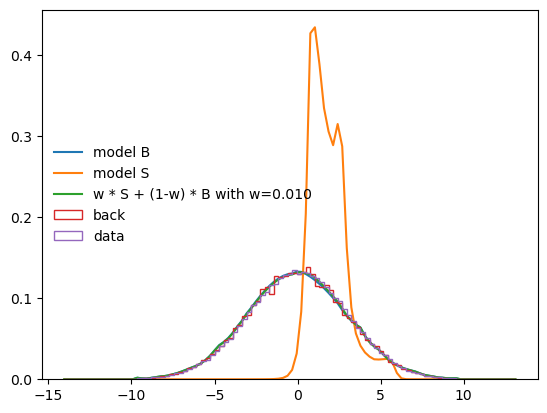

epoch: 7, train_loss: 386057.116, val_loss: 386021.264
w: -4.595


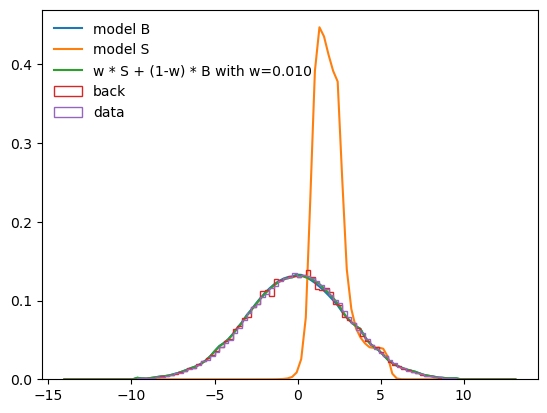

epoch: 8, train_loss: 386055.047, val_loss: 386018.055
w: -4.595


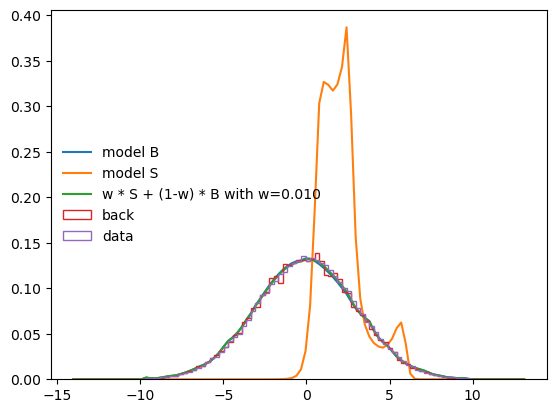

In [13]:
valloss = []
trainloss = []



print(w)

for epoch in range(10):

   train_loss = m_anode(model_S,model_B,w,optimizer,trainloader,noise_data=0,noise_context=0, device=device, mode='train',
                           mode_background='fixed', data_loss_expr='true_likelihood', w_train = True, 
                        clip_grad=False)
   val_loss = m_anode(model_S,model_B,w,optimizer,valloader,noise_data=0,noise_context=0, device=device, mode='val',
                     data_loss_expr='true_likelihood',
                           mode_background='fixed')

   valloss.append(val_loss)
   trainloss.append(train_loss)

   print('epoch: %d, train_loss: %.3f, val_loss: %.3f' % (epoch, train_loss, val_loss))
   print('w: %.3f' % w.item())


   model_B.eval()
   model_S.eval()
   bins = np.linspace(min(X_train), max(X_train), 100).flatten()


   w_ = torch.sigmoid(w).item()
   #w_ = torch.sigmoid(torch.tensor([-6.1035])).item()

   Background = model_B.log_prob(torch.from_numpy(bins.reshape(-1,1)).float().to(device)).exp().detach().cpu().numpy()
   Signal = model_S.log_prob(torch.from_numpy(bins.reshape(-1,1)).float().to(device)).exp().detach().cpu().numpy()

   Data = w_ * Signal + (1-w_) * Background

   plt.plot(bins, Background, label='model B')
   plt.plot(bins, Signal, label='model S')
   plt.plot(bins, Data, label='w * S + (1-w) * B with w=%.3f' % w_)
   plt.hist(X_train[y_train==0], bins=bins, label='back' , density=True, histtype='step')
   plt.hist(X_train[y_train==1], bins=bins, label='data', density=True, histtype='step')

   #plt.hist(x_test[label_test==0], bins=bins, label='back test', density=True, histtype='step')
   #plt.hist(x_test[label_test==1], bins=bins, label='data test', density=True, histtype='step')
   plt.legend(frameon=False)
   plt.show()






In [ ]:
model_B.eval()
model_S.eval()

param_s_sum = 0
param_b_sum = 0

for (param_S, param_B) in zip(model_S.parameters(), model_B.parameters()):
    param_S.requires_grad = False
    param_B.requires_grad = False

    param_s_sum += param_S.sum()
    param_b_sum += param_B.sum()

print(param_s_sum, param_b_sum)



tensor(60.1797, device='cuda:0') tensor(136.0893, device='cuda:0')


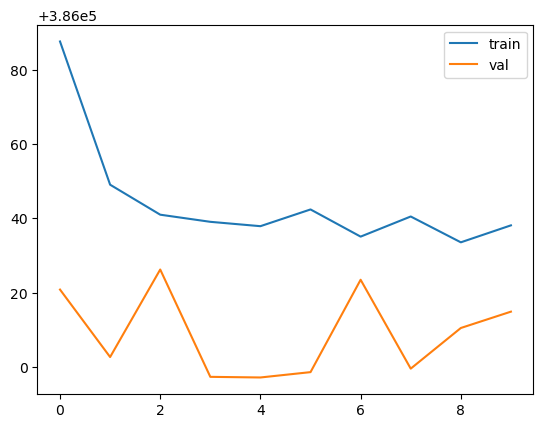

In [71]:
plt.plot(trainloss, label='train')
plt.plot(valloss, label='val')
plt.legend()
plt.show()

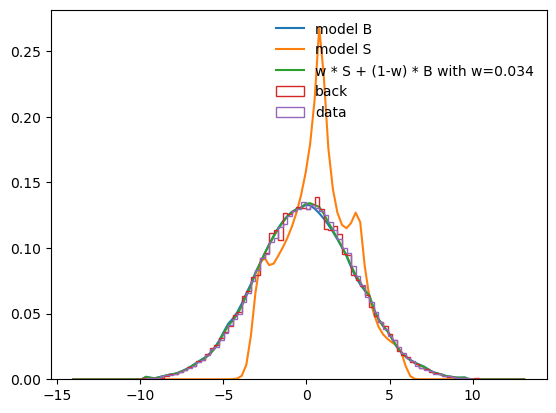

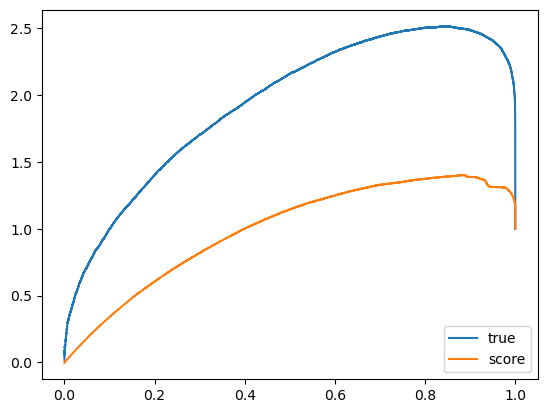

In [79]:
true_likelihoods = {}
true_likelihoods[str(sig_train)] = {}


w1 = true_w[str(sig_train)][0]
w2 = true_w[str(sig_train)][1]

true_likelihoods[str(sig_train)] = p_data(x_test,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_test,back_mean,back_sigma**2)


score_likelihoods = {}
score_likelihoods[str(sig_train)] = {}


model_S.eval()
model_B.eval()
with torch.no_grad():
    log_S = model_S.log_prob(testtensor.to(device)).cpu().detach().numpy()
    log_B = model_B.log_prob(testtensor.to(device)).cpu().detach().numpy()

   # data  = w_ * np.exp(log_S) + (1-w_) * np.exp(log_B)
   # back = np.exp(log_B)



    likelihood_2 = log_S - log_B

    likelihood_2 = np.nan_to_num(likelihood_2, nan=0, posinf=0, neginf=0)

    score_likelihoods[str(sig_train)] = likelihood_2
    

sic_true , tpr_true , auc_true = SIC(label_test, true_likelihoods[str(sig_train)])
sic_score , tpr_score , auc_score = SIC(label_test, likelihood_2)

figure = plt.figure()

plt.plot(tpr_true, sic_true, label='true')
plt.plot(tpr_score, sic_score, label='score')

#plt.plot(tpr_score_2, sic_score_2, label='score epoch 99')


plt.legend(loc='lower right')
plt.show()


In [ ]:
print(auc_true, auc_score, auc_score_2)

0.9364230207285168 0.9298915682788848 0.9287724823349208


In [ ]:
true_w[str(sig_train)][0]

0.021870965217731523

In [ ]:
X_train

tensor([[ 1.6612],
        [-1.2352],
        [ 0.6883],
        ...,
        [-0.7990],
        [-3.0925],
        [ 0.6226]])

In [ ]:
model_B.eval()
model_S.eval()

model_B.to(device)
model_S.to(device)

with torch.no_grad():
    log_S = model_S.log_prob(X_train.to(device)).cpu().numpy()
    log_B = model_B.log_prob(X_train.to(device)).cpu().numpy()

exp_S = np.exp(log_S)
exp_B = np.exp(log_B)


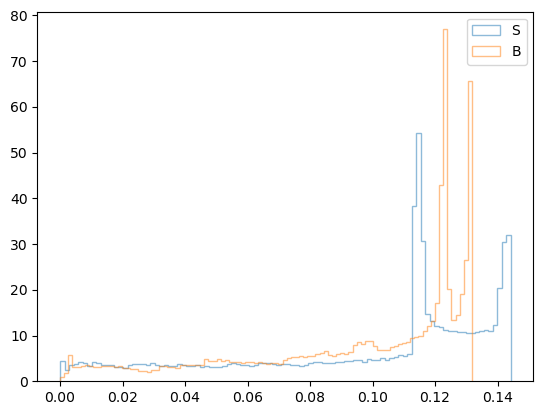

In [ ]:
plt.hist(exp_S, bins=100, alpha=0.5, label='S', density=True, histtype='step')
plt.hist(exp_B, bins=100, alpha=0.5, label='B', density=True, histtype='step')
plt.legend()
plt.show()

In [ ]:
X_train[(exp_B==0) & (exp_S==0)]

tensor([[-14.5105]])

In [ ]:
np.argwhere((exp_B==0) & (exp_S==0))

array([[120407]])

In [89]:
def sigmoid(a, x):
    return 1 / (1 + np.exp(-a * x))

In [96]:
# define derivative of sigmoid
def dsigmoid(a, x):
    return a * sigmoid(a, x) * (1 - sigmoid(a, x))

In [107]:
a_ = 0.01

fx = sigmoid(a_, x)

dsigmoid(a_, x)[fx>0.1]


array([0.00933342, 0.00978872, 0.01025884, 0.01074344, 0.01124206,
       0.0117541 , 0.01227886, 0.01281549, 0.01336297, 0.01392017,
       0.01448579, 0.01505835, 0.01563624, 0.01621766, 0.01680068,
       0.01738319, 0.01796294, 0.01853755, 0.01910451, 0.01966119,
       0.0202049 , 0.02073284, 0.02124221, 0.02173015, 0.02219385,
       0.02263052, 0.02303746, 0.02341206, 0.02375188, 0.02405462,
       0.02431822, 0.02454083, 0.02472087, 0.02485707, 0.02494842,
       0.02499426, 0.02499426, 0.02494842, 0.02485707, 0.02472087,
       0.02454083, 0.02431822, 0.02405462, 0.02375188, 0.02341206,
       0.02303746, 0.02263052, 0.02219385, 0.02173015, 0.02124221,
       0.02073284, 0.0202049 , 0.01966119, 0.01910451, 0.01853755,
       0.01796294, 0.01738319, 0.01680068, 0.01621766, 0.01563624,
       0.01505835, 0.01448579, 0.01392017, 0.01336297, 0.01281549,
       0.01227886, 0.0117541 , 0.01124206, 0.01074344, 0.01025884,
       0.00978872, 0.00933342, 0.0088932 , 0.00846821, 0.00805

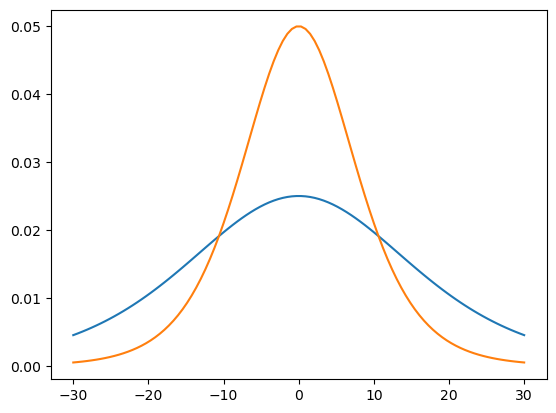

In [99]:
x = np.linspace(-30, 30, 100)
#print(sigmoid(1, x))

#plt.plot(x, dsigmoid(1, x))
plt.plot(x, dsigmoid(0.1, x))
plt.plot(x, dsigmoid(0.2, x))
#plt.ylim(0,0.1)
plt.show()



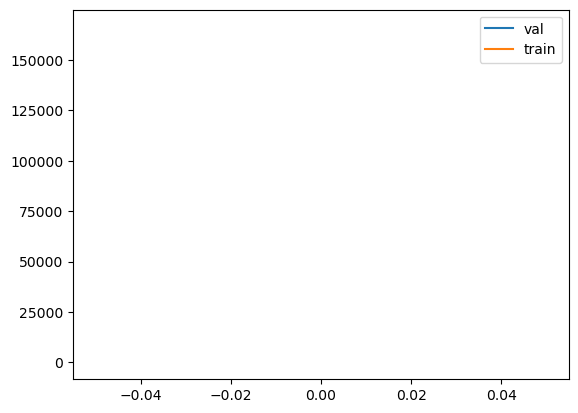

NameError: name 'valloss_list' is not defined

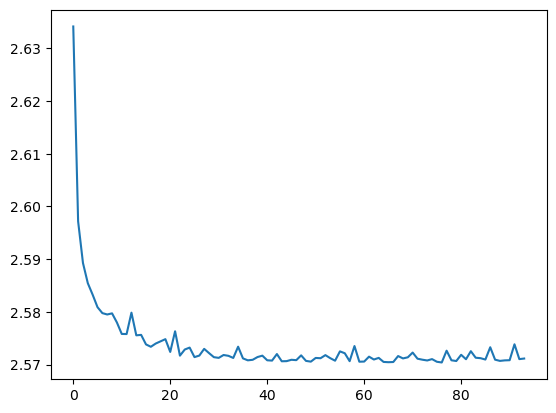

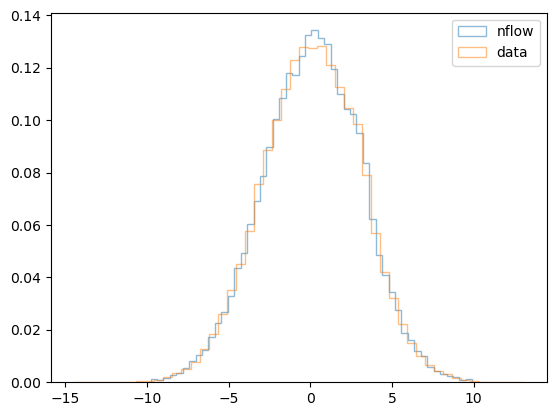

min epoch:  76



 Epoch: 0

 Epoch: 1

 Epoch: 2

 Epoch: 3

 Epoch: 4

 Epoch: 5

 Epoch: 6

 Epoch: 7

 Epoch: 8

 Epoch: 9

 Epoch: 10

 Epoch: 11

 Epoch: 12

 Epoch: 13

 Epoch: 14

 Epoch: 15

 Epoch: 16

 Epoch: 17

 Epoch: 18

 Epoch: 19

 Epoch: 20

 Epoch: 21

 Epoch: 22

 Epoch: 23

 Epoch: 24

 Epoch: 25

 Epoch: 26

 Epoch: 27

 Epoch: 28

 Epoch: 29

 Epoch: 30

 Epoch: 31

 Epoch: 32

 Epoch: 33

 Epoch: 34

 Epoch: 35

 Epoch: 36

 Epoch: 37

 Epoch: 38

 Epoch: 39

 Epoch: 40

 Epoch: 41

 Epoch: 42

 Epoch: 43

 Epoch: 44

 Epoch: 45

 Epoch: 46

 Epoch: 47

 Epoch: 48

 Epoch: 49

 Epoch: 50

 Epoch: 51

 Epoch: 52

 Epoch: 53

 Epoch: 54

 Epoch: 55

 Epoch: 56

 Epoch: 57

 Epoch: 58

 Epoch: 59

 Epoch: 60

 Epoch: 61

 Epoch: 62

 Epoch: 63

 Epoch: 64

 Epoch: 65

 Epoch: 66

 Epoch: 67

 Epoch: 68

 Epoch: 69

 Epoch: 70

 Epoch: 71

 Epoch: 72

 Epoch: 73

 Epoch: 74

 Epoch: 75

 Epoch: 76

 Epoch: 77

 Epoch: 78

 Epoch: 79

 Epoch: 80

 Epoch: 81

 Epoch: 82

 Epoch: 83

 

min epoch:  98


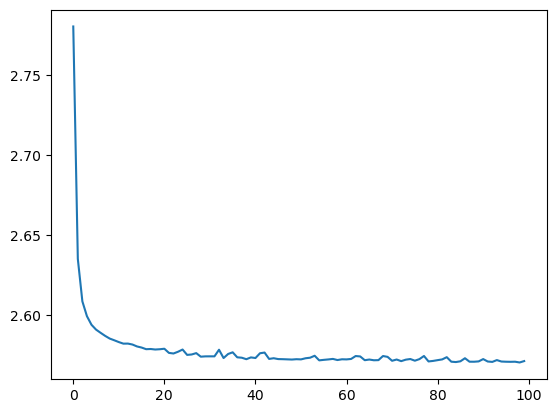

<All keys matched successfully>

<All keys matched successfully>

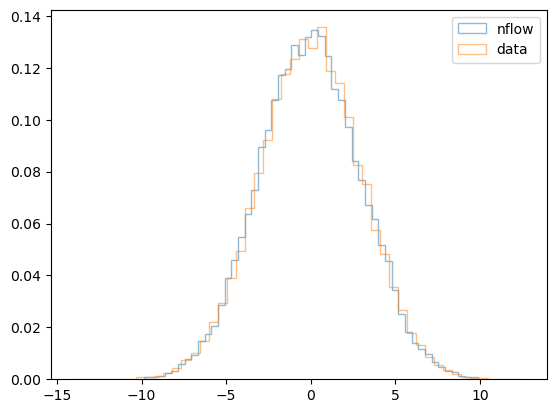

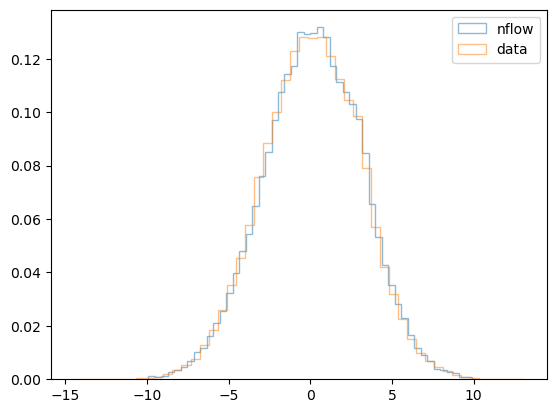

In [ ]:
label_test

array([0., 0., 0., ..., 1., 1., 1.])

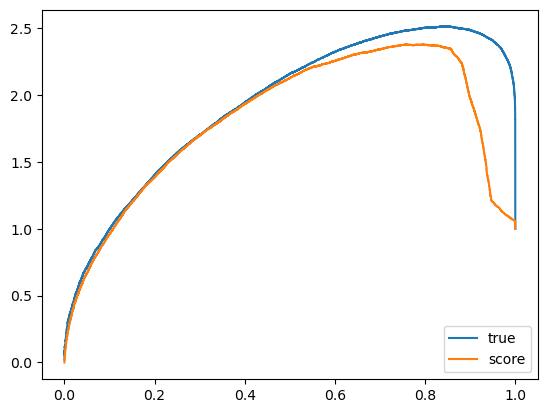